## Imports

In [1]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

data_location = "D:\\data_dump\\deriv_market_data-5M-20221231-20110101.hd5"

### Data Extraction

In [13]:
# get a list of all the symbols we will be working with
symbols = []
with pd.HDFStore(data_location) as hdf:
    keys = hdf.keys()
    for k in keys:
        symbols.append(k[1:])

# for testing only fx pairs
symbols = ['AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'CADCHF', 'CADJPY', 'CHFJPY', 'EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURNOK', 'EURNZD', 'EURUSD', 'GBPAUD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPNOK', 'GBPNZD', 'GBPUSD', 'NZDCAD', 'NZDJPY', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY', 'XAUEUR']

In [14]:
## func to return a list of features from each market data 
def get_market_features(sym):
    df = pd.read_hdf(data_location, key=sym)
    df.asfreq(freq='5T')
    df.set_index(['time'], inplace=True)
    agg_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'tick_volume': 'sum', 'spread': 'mean'}
    df = df.resample(rule='1D').agg(agg_dict) # 1 Day
    df.dropna(how='all', subset=['open', 'high', 'low', 'close', 'spread'], axis=0, inplace=True)
    
    # feature engineering 
    df['returns'] = df['close'].pct_change()
    ann_returns =  df['returns'].mean() * 255
    ann_volatility = df['returns'].std() * np.sqrt(255)
        
    return (sym, ann_returns, ann_volatility)


In [15]:
## run get_market_features on all symbols to build our new data frame
all_market_features = [get_market_features(sym) for sym in symbols]
data = pd.DataFrame.from_records(all_market_features, columns=['ticker', 'ann_returns', 'ann_volatility'], index='ticker')

# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaler, columns=data.columns, index=data.index)
df_scaled = scaled_data
df_scaled.head()

,ann_returns,ann_volatility
ticker,,
AUDCAD,-0.631279,-1.186639
AUDCHF,-1.553377,1.128761
AUDJPY,0.116403,1.299308
AUDNZD,-1.039376,-1.945692
CADCHF,-1.282522,0.593670


## K-Means Clustering

In [16]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Optimum Clusters:  5


In [17]:
# Fit K-Means Model
k_means = KMeans(n_clusters=4)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

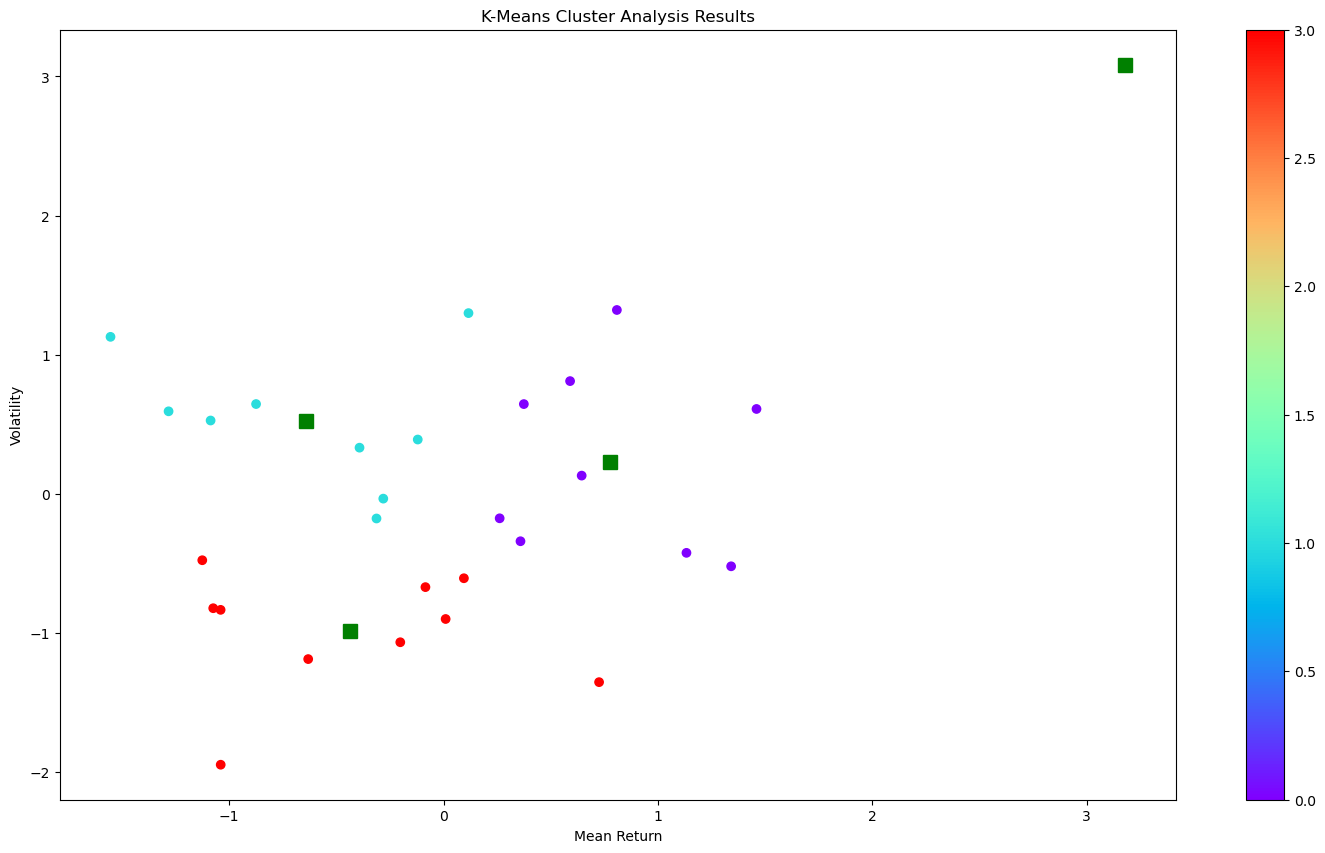

In [18]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [19]:
groupings = {}
for k, v in zip(X.index, k_means.labels_.flatten()):
    if v in groupings:
        groupings[v].append(k)
    else:
        groupings[v] = [k]
groupings

{3: ['AUDCAD',
  'AUDNZD',
  'EURCAD',
  'EURCHF',
  'EURGBP',
  'EURUSD',
  'GBPCAD',
  'GBPUSD',
  'NZDCAD',
  'USDCAD'],
 1: ['AUDCHF',
  'AUDJPY',
  'CADCHF',
  'EURNZD',
  'GBPCHF',
  'GBPNOK',
  'GBPNZD',
  'NZDUSD',
  'USDCHF'],
 0: ['CADJPY',
  'CHFJPY',
  'EURAUD',
  'EURJPY',
  'EURNOK',
  'GBPAUD',
  'GBPJPY',
  'NZDJPY',
  'USDJPY'],
 2: ['XAUEUR']}

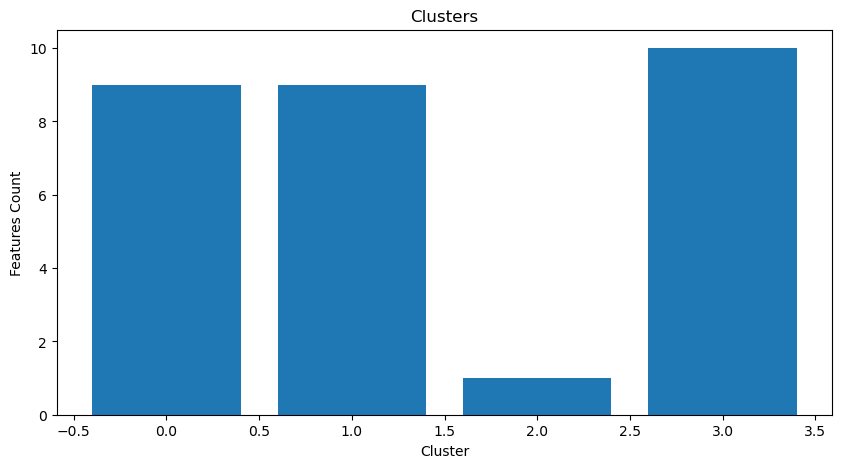

In [20]:
# View number by cluster
keys = sorted(list(groupings.keys()))
values = [len(groupings[k])  for k in keys]

plt.figure(figsize=(10, 5))
plt.bar(keys, values)
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()